In [1]:
def zeros(shape):
    retval = []
    for x in range(shape[0]):
        retval.append([])
        for y in range(shape[1]):
            retval[-1].append(0)
    return retval

match_award      = 20
mismatch_penalty = -1000000
gap_penalty      = -5 # both for opening and extanding

def match_score(alpha, beta):
    if alpha == beta:
        return match_award
    elif alpha == '-' or beta == '-':
        return gap_penalty
    else:
        return mismatch_penalty

def align(pipeline, subhyperpipeline):
    seq1, meta1 = pipeline 
    seq2, meta2 = subhyperpipeline
    "seq2 is the longer one with multiple keys in the dictionary"
    seq1.reverse()    #reverse sequence 1
    seq2.reverse()    #reverse sequence 2 
    meta1.reverse()
    meta2.reverse()
 
    m, n = len(seq1), len(seq2)  # length of two sequences
    
    # Generate DP table and traceback path pointer matrix
    score = zeros((m+1, n+1))      # the DP table
   
    # Calculate DP table
    for i in range(0, m + 1):
        score[i][0] = gap_penalty * i
    for j in range(0, n + 1):
        score[0][j] = gap_penalty * j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + match_score(seq1[i-1], seq2[j-1])
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(match, delete, insert)

    # Traceback and compute the alignment 
    join = []
    joined_meta = []
    
    i,j = m,n # start from the bottom right cell
    while i > 0 and j > 0: # end toching the top or the left edge
        score_current = score[i][j]
        score_diagonal = score[i-1][j-1]
        score_up = score[i][j-1]
        score_left = score[i-1][j]

        if score_current == score_diagonal + match_score(seq1[i-1], seq2[j-1]):
            join.append(seq1[i-1])
            
            temp_dict = meta2[j-1]
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = meta1[i-1][meta1_key]
            joined_meta.append(temp_dict)
            
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            join.append(seq1[i-1])
            
            temp_dict = dict.fromkeys(list(meta2[0].keys()), getFPI("")) 
            #keys are the same for all the dictionaries in meta2, so get keys from the 0th one
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = meta1[i-1][meta1_key]
            joined_meta.append(temp_dict)
            
            i -= 1
        elif score_current == score_up + gap_penalty:
            join.append(seq2[j-1])
            
            temp_dict = meta2[j-1]
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = getFPI("")
            joined_meta.append(temp_dict)
        
            j -= 1


    # Finish tracing up to the top left cell
    while i > 0:
        join.append(seq1[i-1])
        
        temp_dict = dict.fromkeys(list(meta2[0].keys()), getFPI("")) 
        #keys are the same for all the dictionaries in meta2, so get keys from the 0th one
        meta1_key = list(meta1[i-1].keys())[0]
        temp_dict[meta1_key] = meta1[i-1][meta1_key]
        joined_meta.append(temp_dict)
        
        i -= 1
    while j > 0:
        join.append(seq2[j-1])
        
        temp_dict = meta2[j-1]
        meta1_key = list(meta1[i-1].keys())[0]
        temp_dict[meta1_key] = getFPI("")
        joined_meta.append(temp_dict)
        
        j -= 1    
        
    return [join, joined_meta]

def getFPI(fpi):
    if fpi == "":
        return dict.fromkeys(functionPropertiesNames, np.nan)
    
    fpiList = fpi.strip().split('\n')
    fpiDict = {}
    for fp in fpiList:
        fp = fp.strip().split(':')
        fpiDict[fp[0].strip()] = fp[1].strip()

    return fpiDict

def alignHyperPipeline(buffer):
    """
    buffer = { 
                fnA : [ [passA1, passA2, ...., passAN],
                        [{A: fpiA1},  {A: fpiA2},  ...., {A: fpiAN} ] ],
                fnB : [ [passB1, passB2, ...., passBM],
                        [{B: fpiB1},  {B: fpiB2},  ...., {B: fpiBN} ] ]
             }

    subHyperPipeline = [
                            [pass1, pass2, ...., passN],
                            [   {fnA: fpiA1, fnB: fpiB1},
                                {fnA: fpiA2, fnB: fpiB2},
                                ....
                                {fnA: fpiAN, fnB: fpiBN}
                            ]
                       ]
    """
    """print("*"*10," buffer ", "*"*10)
    print(buffer)"""
    _, maxKey= max((len(v), k) for k,v in buffer.items())
    subHyperPipeline = buffer.pop(maxKey)
    
    for key in buffer:
        subHyperPipeline = align(buffer[key], subHyperPipeline)
       
    """
    print("*"*10," subHyperPipeline ", "*"*10)
    print(subHyperPipeline)
    print()"""

    if len(subHyperPipeline[0]) == len(subHyperPipeline[1]):
        return subHyperPipeline
    else: 
        sys.exit("ERROR!!!! FPI MISSING. FIX IT")
        
def getHyperPassPipeline(rawDataList):
    hyperPassPipeline = [[],[]]
    buffer = {}

    for i in range(len(rawDataList)):
        passName = rawDataList[i][1]
        functionName = rawDataList[i][2]
        functionProperties = {functionName: getFPI(rawDataList[i][3])}

        """
        Ignore llvm.lifetim~ functions.
        """
        if functionName.startswith('llvm.lifetime.'):
            continue

        if functionName not in buffer:
            buffer[functionName] = [[],[]]
        buffer[functionName][0].append(passName)
        buffer[functionName][1].append(functionProperties)

    hyperPassPipeline = alignHyperPipeline(buffer)
        
    return hyperPassPipeline

def getDataFrame(hyperPassPipelineDict):
    functionPropertiesNames = ['BasicBlockCount', 'BlocksReachedFromConditionalInstruction',
                               'Uses', 'DirectCallsToDefinedFunctions', 'LoadInstCount', 
                               'StoreInstCount', 'MaxLoopDepth', 'TopLevelLoopCount']

    cols = []
    data = []
    fnNameIndexPointer = {}

    cols.append(('Pass Number','Function Name'))

    for passNo, fpiSet in hyperPassPipelineDict.items():
        for fp in functionPropertiesNames:
            cols.append((passNo, fp))
        for fnName, fpi in fpiSet.items():
            if passNo == 0:
                data.append([fnName])
                fnNameIndexPointer[fnName] = len(data)-1
            for _, value in fpi.items():
                data[fnNameIndexPointer[fnName]].append(value)

    return pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(cols))

In [2]:
import sys
import numpy as np
import pandas as pd
    
fileName = 'SPASS_clause.c.txt'
functionPropertiesNames = ['BasicBlockCount', 'BlocksReachedFromConditionalInstruction',
                           'Uses', 'DirectCallsToDefinedFunctions', 'LoadInstCount', 
                           'StoreInstCount', 'MaxLoopDepth', 'TopLevelLoopCount']
numFunctionProperties = len(functionPropertiesNames)
    
with open(fileName) as inFile:
    rawData = inFile.read()

rawDataList = list(map(str.strip, rawData.strip().split('***')))[1:]

for i in range(len(rawDataList)):
    rawDataList[i] = list(map(str.strip, rawDataList[i].strip().split('#')))

hyperPassPipeline = getHyperPassPipeline(rawDataList)

hyperPassPipelineDict = dict(zip(list(range(len(hyperPassPipeline[0]))), hyperPassPipeline[1]))

In [3]:
passPipelineDF = getDataFrame(hyperPassPipelineDict)
passPipelineDF

Pass Number               0  \
                     Function Name BasicBlockCount   
0                   term_TopSymbol               1   
1          clause_LiteralIsLiteral               3   
2               symbol_IsPredicate               3   
3          clause_LiteralPredicate               1   
4      clause_LiteralComputeWeight              17   
..                             ...             ...   
295  memory_CalculateRealBlockSize               5   
296         clause_LiteralsCompare               1   
297            clause_UpdateWeight               1   
298      symbol_IsStandardVariable               3   
299                    list_Member               7   

                                                  \
    BlocksReachedFromConditionalInstruction Uses   
0                                         0   36   
1                                         2    2   
2                                         2    2   
3                                         0    7   
4                                        12    3   
..                                      ...  ...   
295                                       4    1   
296                                       0    1   
297                                       0    1   
298                                       2    1   
299                                       4    1   

                                                                             \
    DirectCallsToDefinedFunctions LoadInstCount StoreInstCount MaxLoopDepth   
0                               0             2              1            0   
1                               2             2              1            0   
2                               2             2              1            0   
3                               2             1              1            0   
4                              20            14              9            2   
..                            ...           ...            ...          ...   
295                             0            11              4            0   
296                             2             2              2            0   
297                             1             3              3            0   
298                             1             2              1            0   
299                             3             6              6            1   

                                    1  ...          284                    \
    TopLevelLoopCount BasicBlockCount  ... MaxLoopDepth TopLevelLoopCount   
0                   0               1  ...          NaN               NaN   
1                   0               3  ...            0                 0   
2                   0               3  ...          NaN               NaN   
3                   0               1  ...          NaN               NaN   
4                   1              17  ...            2                 1   
..                ...             ...  ...          ...               ...   
295                 0               5  ...          NaN               NaN   
296                 0               1  ...            0                 0   
297                 0               1  ...          NaN               NaN   
298                 0               3  ...          NaN               NaN   
299                 1               7  ...          NaN               NaN   

                285                                               \
    BasicBlockCount BlocksReachedFromConditionalInstruction Uses   
0               NaN                                     NaN  NaN   
1                 6                                       6    1   
2               NaN                                     NaN  NaN   
3               NaN                                     NaN  NaN   
4                16                                      16    1   
..              ...                                     ...  ...   
295             NaN                                     NaN  NaN   
2

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
%matplotlib inline

In [6]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(passPipelineDF.drop(columns=['Function Name'], level=1))
X_scale

array([[0.        , 0.        , 0.40229885, ...,        nan,        nan,
               nan],
       [0.03333333, 0.03703704, 0.01149425, ..., 0.        , 0.        ,
        0.        ],
       [0.03333333, 0.03703704, 0.01149425, ...,        nan,        nan,
               nan],
       ...,
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.03333333, 0.03703704, 0.        , ...,        nan,        nan,
               nan],
       [0.1       , 0.07407407, 0.        , ...,        nan,        nan,
               nan]])

In [7]:
passPipelineDFScale = pd.DataFrame(X_scale, columns=passPipelineDF.drop(columns=['Function Name'], level=1).columns)
passPipelineDFScale

0                                                      \
    BasicBlockCount BlocksReachedFromConditionalInstruction      Uses   
0          0.000000                                0.000000  0.402299   
1          0.033333                                0.037037  0.011494   
2          0.033333                                0.037037  0.011494   
3          0.000000                                0.000000  0.068966   
4          0.266667                                0.222222  0.022989   
..              ...                                     ...       ...   
295        0.066667                                0.074074  0.000000   
296        0.000000                                0.000000  0.000000   
297        0.000000                                0.000000  0.000000   
298        0.033333                                0.037037  0.000000   
299        0.100000                                0.074074  0.000000   

                                                                             \
    DirectCallsToDefinedFunctions LoadInstCount StoreInstCount MaxLoopDepth   
0                        0.000000      0.027778       0.024390     0.000000   
1                        0.041667      0.027778       0.024390     0.000000   
2                        0.041667      0.027778       0.024390     0.000000   
3                        0.041667      0.013889       0.024390     0.000000   
4                        0.416667      0.194444       0.219512     0.666667   
..                            ...           ...            ...          ...   
295                      0.000000      0.152778       0.097561     0.000000   
296                      0.041667      0.027778       0.048780     0.000000   
297                      0.020833      0.041667       0.073171     0.000000   
298                      0.020833      0.027778       0.024390     0.000000   
299                      0.062500      0.083333       0.146341     0.333333   

                                  1                                            \
    TopLevelLoopCount BasicBlockCount BlocksReachedFromConditionalInstruction   
0                 0.0        0.000000                                0.000000   
1                 0.0        0.033333                                0.037037   
2                 0.0        0.033333                                0.037037   
3                 0.0        0.000000                                0.000000   
4                 0.2        0.266667                                0.222222   
..                ...             ...                                     ...   
295               0.0        0.066667                                0.074074   
296               0.0        0.000000                                0.000000   
297               0.0        0.000000                                0.000000   
298               0.0        0.033333                                0.037037   
299               0.2        0.100000                                0.074074   

     ...          284                               285  \
     ... MaxLoopDepth TopLevelLoopCount BasicBlockCount   
0    ...          NaN               NaN             NaN   
1    ...          0.0               0.0        0.089286   
2    ...          NaN               NaN             NaN   
3    ...          NaN               NaN             NaN   
4    ...          0.5               0.1        0.267857   
..   ...          ...               ...             ...   
295  ...          NaN               NaN             NaN   
296  ...          0.0               0.0        0.000000   
297  ...          NaN               NaN             NaN   
298  ...          NaN               NaN             NaN   
299  ...          NaN               NaN             NaN   

                                                  \
    BlocksReachedFromConditionalInstruction Uses   
0                                       NaN  NaN   
1                                  0.081081  0.0   
2       

In [9]:
passPipelineDFScale.fillna(-1, inplace=True)

# KMeans on Original Dataset

Text(0, 0.5, 'Inertia')

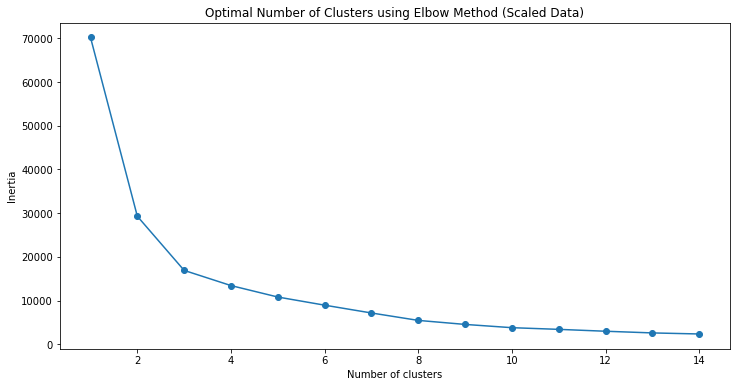

In [16]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(passPipelineDFScale)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Elbow Method: This is a very popular iterative statistical technique for determining the optimal number of clusters by actually running the K-Means algorithm for a range of cluster values. The elbow method calculates the sum of squared distances from each point to its assigned centroid for each iteration of KMeans. Each iteration runs through a different number of clusters. The result is a line chart that displays the sum of squared distances at each cluster. We want to select the number of clusters at the elbow of the line chart or the lowest sum of squared distances (ie. Inertia) at the lowest number of clusters. The lower the sum of squares distances means the data inside each cluster are more tightly grouped.

Therefore, n_clusters=3.

In [19]:
df_scale2 = passPipelineDFScale.copy()
kmeans_scale = KMeans(n_clusters=3, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df_scale2)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_scale2, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([df_scale2, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.6824201793779611


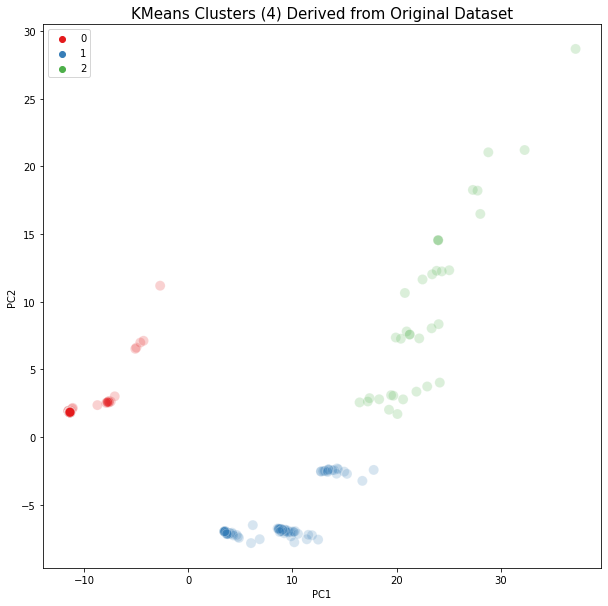

In [20]:
pca2 = PCA(n_components=3).fit(df_scale2)
pca2d = pca2.transform(df_scale2)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [22]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = labels_scale
trace = go.Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

Text(0.5, 0, 'Pass')

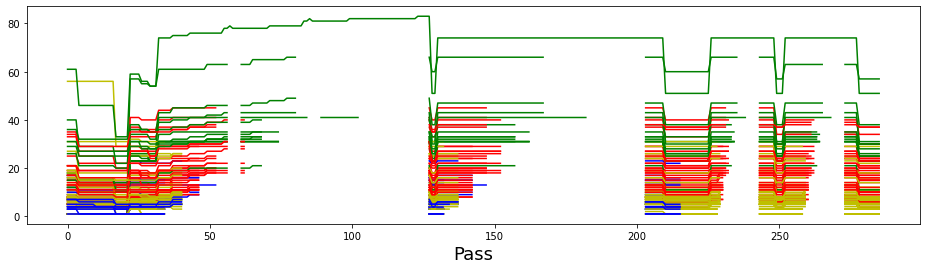

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (16,4))

joined_df = BasicBlockCountDF.copy()

cmap = { 0:'r',1:'b',2:'y',3:'g',4:'k' }

for index, row in joined_df.iterrows():
    axs.plot(row[:-1], label=index, color=cmap[row['cluster_scaled']])
axs.set_xlabel("Pass", fontsize=18)

Text(0.5, 0, 'Pass')

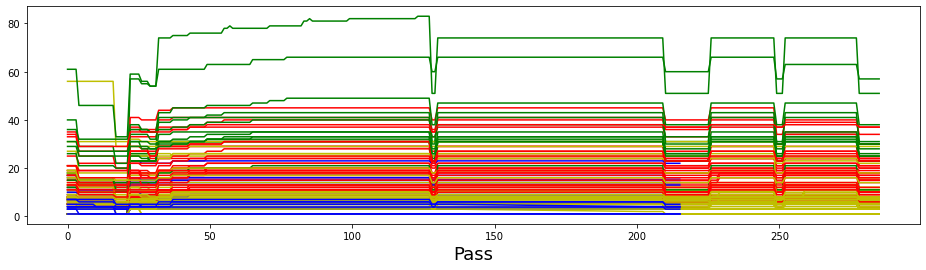

In [14]:
fig, axs = plt.subplots(1, 1, figsize = (16,4))

joined_df = BasicBlockCountDF.copy()

cmap = { 0:'r',1:'b',2:'y',3:'g',4:'k' }

for index, row in joined_df.iterrows():
    axs = sns.lineplot(data=row[:-1], color=cmap[row['cluster_scaled']])
axs.set_xlabel("Pass", fontsize=18)

# Feature Reduction via PCA

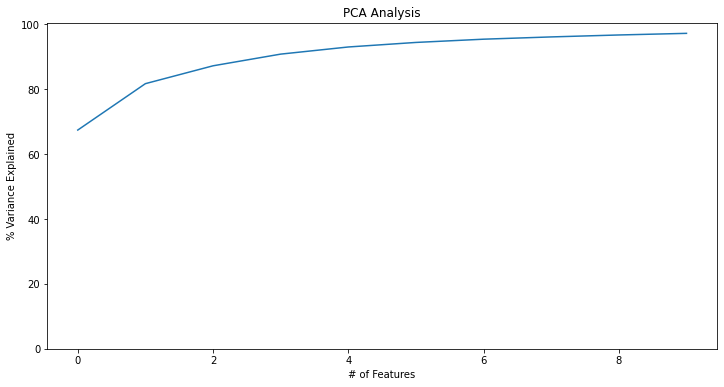

In [30]:
#n_components=2288 because we have 2288 features in the dataset
pca = PCA(n_components=10)
pca.fit(passPipelineDFScale)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

By examining the amount of variance each principal component encompasses we can see that the first 3 principal components explain roughly 85% of the variance. Finally, we apply PCA again and reduce our dataset to 3 principal components.

In [35]:
pca = PCA(n_components=3)
pca_scale = pca.fit_transform(passPipelineDFScale)
pca_df_scale = pd.DataFrame(pca_scale, columns=['pc1','pc2','pc3'])
print("% of variance explained by each PC")
print(pca.explained_variance_ratio_)

% of variance explained by each PC
[0.67361994 0.14284712 0.0549846 ]


Text(0, 0.5, 'Inertia')

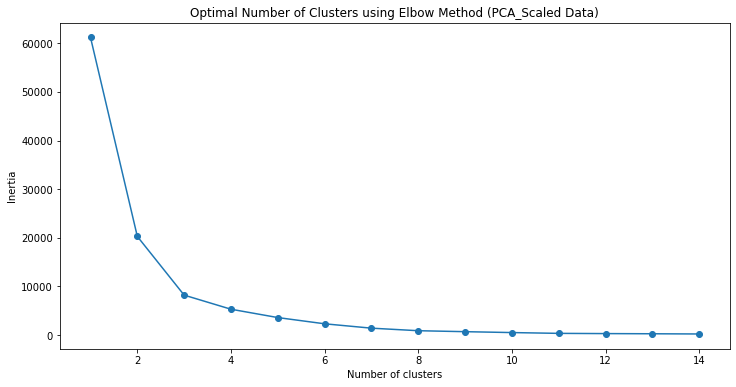

In [36]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(pca_df_scale)
    sse.append([k, km.inertia_])
    
pca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (PCA_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [39]:
kmeans_pca_scale = KMeans(n_clusters=3, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(pca_df_scale)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(pca_df_scale, kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_pca_scale.labels_
clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)

KMeans PCA Scaled Silhouette Score: 0.7756293383279484


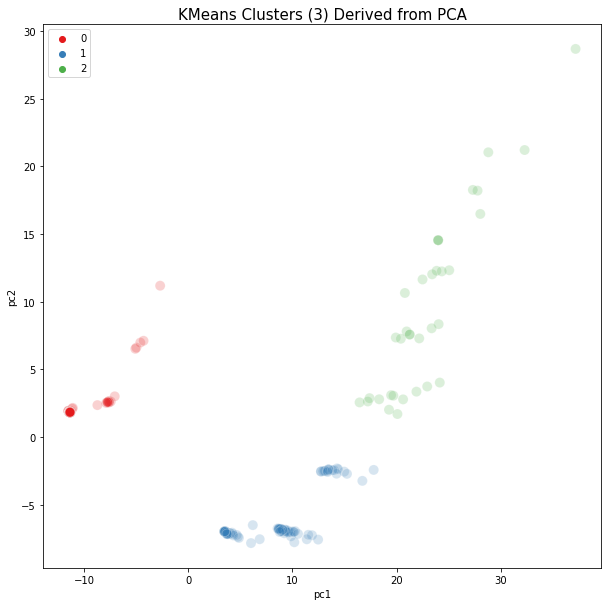

In [102]:
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1], hue=labels_pca_scale, palette='Set1', s=100, alpha=0.2).set_title('KMeans Clusters (3) Derived from PCA', fontsize=15)
plt.legend()
plt.show()

In [41]:
#get only one property
BasicBlockCountDF = passPipelineDF.drop(columns=['Pass Number'], level=0)
BasicBlockCountDF = BasicBlockCountDF[BasicBlockCountDF.columns[0::8]]
BasicBlockCountDF.columns = list(range(len(hyperPassPipeline[0])))
BasicBlockCountDF = BasicBlockCountDF.apply(pd.to_numeric)
BasicBlockCountDF = pd.concat([BasicBlockCountDF, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)
BasicBlockCountDF

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,cluster_scaled
0,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,3,3,3,3,3,3,3,3,3,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1
2,3,3,3,3,3,3,3,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,17,17,17,17,14,14,14,14,14,14,...,17.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,5,5,5,5,5,5,5,5,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
296,1,1,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
297,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
298,3,3,3,3,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Text(0.5, 0, 'Pass')

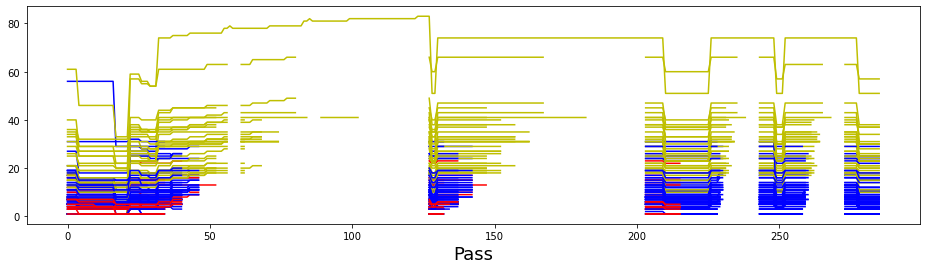

In [57]:
fig, axs = plt.subplots(1, 1, figsize = (16,4))

joined_df = BasicBlockCountDF.copy()

cmap = { 0:'r',1:'b',2:'y',3:'g',4:'k' }

for index, row in joined_df.iterrows():
    axs.plot(row[:-1], label=index, color=cmap[row['cluster_scaled']])
axs.set_xlabel("Pass", fontsize=18)

In [81]:
functions[0][0]

'term_TopSymbol'

In [103]:
import plotly.graph_objects as go

joined_df = BasicBlockCountDF.copy()

cmap = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
functions = passPipelineDF.loc[:, [('Pass Number', 'Function Name')]].to_numpy()

fig = go.Figure(go.Scatter(
    hovertemplate =
    '<i>Price</i>: $%{y:.2f}'+
    '<br><b>X</b>: %{x}<br>'+
    '<b>%{text}</b>',
    showlegend = False))

for index, row in joined_df.iterrows():
    fn_name = functions[index][0]
    fig.add_trace(go.Scatter(x=row[:-1].index.to_numpy(), y=row[:-1].to_numpy(),
                    hovertemplate = 'Function Name: ' + fn_name 
                                    + '<br>Function No: ' + str(index) 
                                    + '<br>Pass No: %{x} ' 
                                    + '<br>BasicBlockCount: %{y}',
                    mode='lines',
                    marker_color=cmap[int(row['cluster_scaled'])],
                    name='',
                    showlegend = False)
)
fig.show()
